In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# 1. Preprocess the Data

This part we give the formula and the head 5 lines of the data

In [2]:
# Read FEDs data 
dat = pd.read_csv('feds.csv')
dat.Date = pd.to_datetime(dat.Date)

In [3]:
# Read .dat file of Fama Bliss Zero Coupon Bond prices used on the original paper
with open('bondprice.dat','r') as f:
    next(f) # skip first row
    next(f)
    next(f)
    next(f)
    df = pd.DataFrame(l.rstrip().split() for l in f)
df.columns = ['Date', 'Year 1', 'Year 2', 'Year 3', 'Year 4', 'Year 5']
df.Date = pd.to_datetime(df.Date)
fb_dat = df

In [4]:
# Create new columns with month and year from each date
dat['year'] =  pd.DatetimeIndex(dat.Date).year
dat['month'] =  pd.DatetimeIndex(dat.Date).month

fb_dat['year'] = pd.DatetimeIndex(fb_dat.Date).year
fb_dat['month'] = pd.DatetimeIndex(fb_dat.Date).month

In [5]:
# Get only the values correspoding to the first trading day of each month
dat_month = dat.groupby(['year','month']).first().reset_index()
year = dat_month.pop('year')
month = dat_month.pop('month')

dat_month = dat_month.set_index('Date')
dat_month = dat_month[1:]

fb_dat_month = fb_dat.groupby(['year','month']).first().reset_index()
fb_dat_month.pop('year')
fb_dat_month.pop('month')
fb_dat_month = fb_dat_month.set_index('Date')
fb_dat_month = fb_dat_month[1:]
fb_dat_month = fb_dat_month.astype(float)
dat_month.head()

,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,
1961-07-31,2.7780,3.2304,3.5068,3.6787,3.7907,3.8678,3.9234,NaN,NaN,NaN
1961-08-31,2.9863,3.3990,3.6481,3.7919,3.8812,3.9412,3.9841,NaN,NaN,NaN
1961-09-29,2.9358,3.3250,3.5412,3.6661,3.7442,3.7968,3.8345,NaN,NaN,NaN
1961-10-31,2.8936,3.2396,3.4616,3.6087,3.7096,3.7813,3.8339,NaN,NaN,NaN
1961-11-30,3.0000,3.3013,3.5216,3.6775,3.7825,3.8477,3.8817,NaN,NaN,NaN


In [6]:
# Add columns of all ones at the begining of the data frame and change bond prices to a face value of 1
bond_price = dat_month / 100

bond_price['spot'] = np.ones(len(bond_price)) 
cols = bond_price.columns.tolist()
bond_price = bond_price[[cols[-1]] + cols[:-1]] 

fb_bond_price = fb_dat_month/100
fb_bond_price['spot'] = np.ones(len(fb_bond_price))
fb_cols = fb_bond_price.columns.tolist()
fb_bond_price = fb_bond_price[[cols[-1]] + fb_cols[:-1]]

bond_price.head()


,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,1.0,0.027780,0.032304,0.035068,0.036787,0.037907,0.038678,0.039234,NaN,NaN,NaN
1961-08-31,1.0,0.029863,0.033990,0.036481,0.037919,0.038812,0.039412,0.039841,NaN,NaN,NaN
1961-09-29,1.0,0.029358,0.033250,0.035412,0.036661,0.037442,0.037968,0.038345,NaN,NaN,NaN
1961-10-31,1.0,0.028936,0.032396,0.034616,0.036087,0.037096,0.037813,0.038339,NaN,NaN,NaN
1961-11-30,1.0,0.030000,0.033013,0.035216,0.036775,0.037825,0.038477,0.038817,NaN,NaN,NaN


In [7]:
for i in range(11):
    bond_price.iloc[:, i] = np.exp(-bond_price.iloc[:, i] * i)
bond_price.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,1.0,0.972602,0.937435,0.900141,0.863166,0.827344,0.792892,0.759847,NaN,NaN,NaN
1961-08-31,1.0,0.970578,0.934279,0.896333,0.859267,0.823608,0.789408,0.756625,NaN,NaN,NaN
1961-09-29,1.0,0.971069,0.935663,0.899212,0.863601,0.829270,0.796277,0.764590,NaN,NaN,NaN
1961-10-31,1.0,0.971479,0.937262,0.901362,0.865586,0.830705,0.797018,0.764623,NaN,NaN,NaN
1961-11-30,1.0,0.970446,0.936107,0.899741,0.863208,0.827683,0.793849,0.762068,NaN,NaN,NaN


$$p_t^{(n)} = ln(bondPrice)$$

In [8]:
p = np.log(bond_price)
fb_p = np.log(fb_bond_price)
p.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,0.0,-0.027780,-0.064608,-0.105204,-0.147148,-0.189535,-0.232068,-0.274638,NaN,NaN,NaN
1961-08-31,0.0,-0.029863,-0.067980,-0.109443,-0.151676,-0.194060,-0.236472,-0.278887,NaN,NaN,NaN
1961-09-29,0.0,-0.029358,-0.066500,-0.106236,-0.146644,-0.187210,-0.227808,-0.268415,NaN,NaN,NaN
1961-10-31,0.0,-0.028936,-0.064792,-0.103848,-0.144348,-0.185480,-0.226878,-0.268373,NaN,NaN,NaN
1961-11-30,0.0,-0.030000,-0.066026,-0.105648,-0.147100,-0.189125,-0.230862,-0.271719,NaN,NaN,NaN


$$ y_t{(n)} = -\frac1n p_t^{(n)}$$

In [9]:
y = p.copy()
for i in range(1,11):
    y.iloc[:,i] = -1.0/(i) * y.iloc[:,i]
y.spot = np.ones(len(y))

fb_y = fb_p.copy()
for i in range(1,6):
    fb_y.iloc[:,i] = -1.0/(i) * fb_y.iloc[:,i]
fb_y.spot = np.ones(len(fb_y))
fb_y.head()

,spot,Year 1,Year 2,Year 3,Year 4,Year 5
Date,,,,,,
1952-07-31,1.0,0.019234,0.020250,0.020870,0.020007,0.021401
1952-08-29,1.0,0.019611,0.020541,0.021399,0.020449,0.022025
1952-09-30,1.0,0.019886,0.020880,0.021495,0.020585,0.022930
1952-10-31,1.0,0.019071,0.020546,0.021484,0.021038,0.021684
1952-11-28,1.0,0.020662,0.021757,0.021904,0.021177,0.021867


$$f_t^{(n)} = p_t^{(n-1)} - p_t^{(n)}$$

In [10]:
f = p.copy()
f = -f.diff(axis = 1)
f.spot = np.ones(len(f))

fb_f = fb_p.copy()
fb_f = -fb_f.diff(axis = 1)
fb_f.spot = np.ones(len(fb_f))
f.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,1.0,0.027780,0.036828,0.040596,0.041944,0.042387,0.042533,0.042570,NaN,NaN,NaN
1961-08-31,1.0,0.029863,0.038117,0.041463,0.042233,0.042384,0.042412,0.042415,NaN,NaN,NaN
1961-09-29,1.0,0.029358,0.037142,0.039736,0.040408,0.040566,0.040598,0.040607,NaN,NaN,NaN
1961-10-31,1.0,0.028936,0.035856,0.039056,0.040500,0.041132,0.041398,0.041495,NaN,NaN,NaN
1961-11-30,1.0,0.030000,0.036026,0.039622,0.041452,0.042025,0.041737,0.040857,NaN,NaN,NaN


$$r_{t+1}^{(n)} = p_{t+1}^{(n-1)} - _t^{(n)}$$

In [11]:
p1 = p.copy()
p1 = p1.shift(-12) # t+1
p1 = p1.shift(1, axis=1) # n-1
r = p1 - p

fb_p1 = fb_p.copy()
fb_p1 = fb_p1.shift(-12)
fb_p1 = fb_p1.shift(1, axis = 1)
fb_r = fb_p1 - fb_p
r.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,NaN,0.027780,0.033298,0.037274,0.039802,0.041295,0.042158,0.042654,NaN,NaN,NaN
1961-08-31,NaN,0.029863,0.038200,0.046633,0.051503,0.053608,0.054127,0.053821,NaN,NaN,NaN
1961-09-29,NaN,0.029358,0.037903,0.044746,0.047620,0.047694,0.046203,0.043919,NaN,NaN,NaN
1961-10-31,NaN,0.028936,0.036415,0.041852,0.044868,0.046000,0.045863,0.044927,NaN,NaN,NaN
1961-11-30,NaN,0.030000,0.036376,0.042592,0.047194,0.049909,0.050757,0.049767,NaN,NaN,NaN


$$ rx_{t+1}^{(n)} = r_{t+1}^{(n)} - y_t^{(1)}$$

In [12]:
y1 = y.copy()
for i in range(2,11):
    y1.iloc[:,i] = y1.iloc[:,1]
rx = r - y1

fb_y1 = fb_y.copy()
for i in range(2,6):
    fb_y1.iloc[:,i] = fb_y1.iloc[:,1]
fb_rx = fb_r - fb_y1

rx.head()

,spot,SVENY01,SVENY02,SVENY03,SVENY04,SVENY05,SVENY06,SVENY07,SVENY08,SVENY09,SVENY10
Date,,,,,,,,,,,
1961-07-31,NaN,0.0,0.005518,0.009494,0.012022,0.013515,0.014378,0.014874,NaN,NaN,NaN
1961-08-31,NaN,0.0,0.008337,0.016770,0.021640,0.023745,0.024264,0.023958,NaN,NaN,NaN
1961-09-29,NaN,0.0,0.008545,0.015388,0.018262,0.018336,0.016845,0.014561,NaN,NaN,NaN
1961-10-31,NaN,0.0,0.007479,0.012916,0.015932,0.017064,0.016927,0.015991,NaN,NaN,NaN
1961-11-30,NaN,0.0,0.006376,0.012592,0.017194,0.019909,0.020757,0.019767,NaN,NaN,NaN


# 2. The Regression

In [13]:
# Set train and test data
idx_5 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1964-1-1'))
idx_10 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('1972-1-1'))
idx_train5 = (y.index < pd.to_datetime('2008-1-1')) & (y.index > pd.to_datetime('1964-1-1'))
idx_test5 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('2008-1-1'))
idx_train10 = (y.index < pd.to_datetime('2008-1-1')) & (y.index > pd.to_datetime('1972-1-1'))
idx_test10 = (y.index < pd.to_datetime('2017-9-1')) & (y.index > pd.to_datetime('2008-1-1'))

# Select 5 year data
yt5 = y[idx_5].iloc[:,1:6]
ft5 = f[idx_5].iloc[:,1:6]
rxt5 = rx[idx_5].iloc[:,2:6]
rxt_bar5 = rxt5.mean(axis = 1)

# Select 10 year data
yt10 = y[idx_10].iloc[:,1:11]
ft10 = f[idx_10].iloc[:,1:11]
rxt10 = rx[idx_10].iloc[:,2:11]
rxt_bar10 = rxt10.mean(axis = 1)


# Select 5 year train data
yt_train5 = y[idx_train5].iloc[:,1:6]
ft_train5 = f[idx_train5].iloc[:,1:6]
rxt_train5 = rx[idx_train5].iloc[:,2:6]
rxt_bar_train5 = rxt_train5.mean(axis = 1)

# Select 5 year test data
yt_test5 = y[idx_test5].iloc[:,1:6]
ft_test5 = f[idx_test5].iloc[:,1:6]
rxt_test5 = rx[idx_test5].iloc[:,2:6]
rxt_bar_test5 = rxt_test5.mean(axis = 1)

# Select 10 year train data
yt_train10 = y[idx_train10].iloc[:,1:11]
ft_train10 = f[idx_train10].iloc[:,1:11]
rxt_train10 = rx[idx_train10].iloc[:,2:11]
rxt_bar_train10 = rxt_train10.mean(axis = 1)

# Select 10 year test data
yt_test10 = y[idx_test10].iloc[:,1:11]
ft_test10 = f[idx_test10].iloc[:,1:11]
rxt_test10 = rx[idx_test10].iloc[:,2:11]
rxt_bar_test10 = rxt_test10.mean(axis = 1)

# Comparison Excess Returns FEDs VS Fama Bliss 

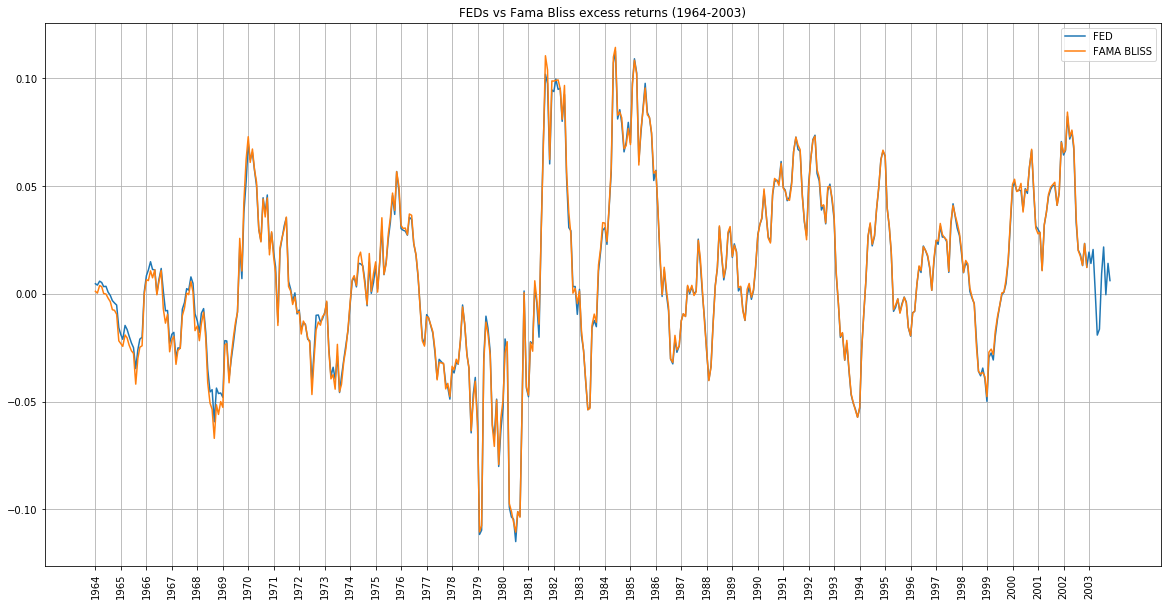

In [96]:
# Compute average Excess returns from maturities 1-5 years
rxt_fed = rx.iloc[:,2:6].mean(axis = 1)
rxt_fb = fb_rx.iloc[:,2:6].mean(axis = 1)

plt.figure(figsize=(20,10))
plt.plot(rxt_fed[(y.index < pd.to_datetime('2003-12-1')) & (y.index > pd.to_datetime('1964-1-1'))], label='FED')
plt.plot(rxt_fb[(fb_y.index < pd.to_datetime('2003-12-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))], label='FAMA BLISS')
plt.xticks(rxt_fb[(fb_y.index < pd.to_datetime('2003-12-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))].index[::12],
           rotation = 90)
plt.grid()
plt.legend()
plt.title('FEDs vs Fama Bliss excess returns (1964-2003)')
plt.show();

# Single factor model regression

## FAMA BLISS: Train set (1964 - 2003), Test set (1964 - 2003). Up to 5-year maturities

In [16]:
fb_yt5 = fb_y[(fb_y.index < pd.to_datetime('2003-1-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))].iloc[:,1:6]
fb_ft5 = fb_f[(fb_y.index < pd.to_datetime('2003-1-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))].iloc[:,1:6]
fb_rxt5 = fb_rx[(fb_y.index < pd.to_datetime('2003-1-1')) & (fb_y.index > pd.to_datetime('1964-1-1'))].iloc[:,2:6]
fb_rxt_bar5 = fb_rxt5.mean(axis = 1)

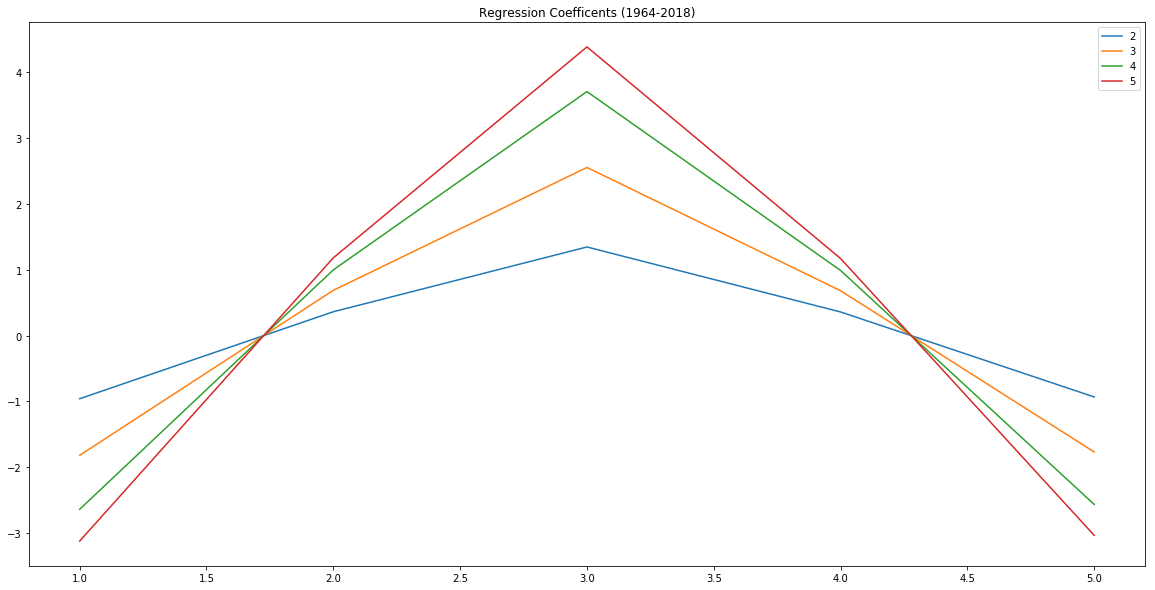

In [46]:
fb_model = LinearRegression()
fb_R_sq_model = np.zeros(4)

fb_model.fit(fb_ft5,fb_rxt_bar5)
fb_gamma = fb_model.coef_
fb_R_sq_model = fb_model.score(fb_ft5,fb_rxt_bar5)

fb_aux = pd.DataFrame(np.sum((fb_ft5).mul(fb_gamma), axis = 1) + fb_model.intercept_)
fb_aux.insert(0, 'ones', np.ones(len(fb_aux)))

fb_models = []
fb_b = np.zeros(4)
fb_R_sq = np.zeros(4)
fb_rxt_predict = fb_rxt5.copy()

for i in range(4):
    fb_model_b = LinearRegression(fit_intercept=False)
    fb_model_b.fit(fb_aux,fb_rxt5.iloc[:,i])
    fb_b[i] = fb_model_b.coef_[1]
    fb_rxt_predict.iloc[:,i] = fb_model_b.predict(fb_aux)
    fb_R_sq[i] = fb_model_b.score(fb_aux,fb_rxt5.iloc[:,i])
    fb_models.append(fb_model_b)
plt.figure(figsize=(20,10))
for i in range(4):
    plt.plot(range(1,6),fb_b[i]*fb_gamma, label = str(i+2))
fb_rxt_predict_bar = np.mean(fb_rxt_predict, axis = 1)
plt.legend()
plt.title('Regression Coefficents (1964-2018)')
plt.show();

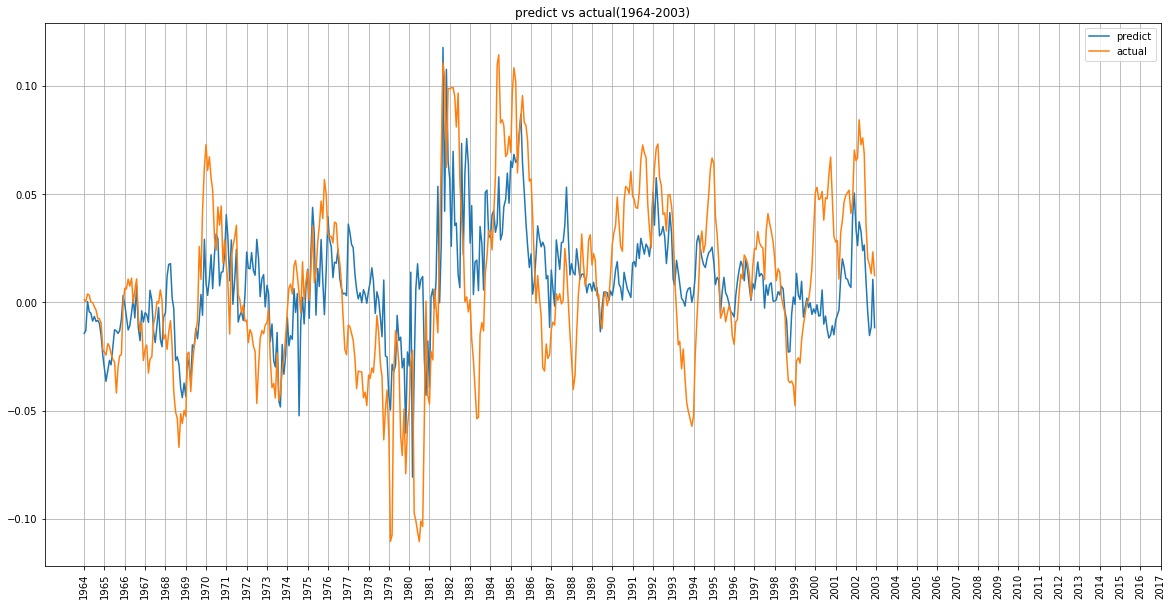

array([ 0.31361257,  0.33730054,  0.3700371 ,  0.34471039])

In [94]:
plt.figure(figsize=(20,10))
plt.plot(fb_rxt_predict_bar, label='predict')
plt.plot(fb_rxt_bar5, label='actual')
plt.xticks(rxt_bar5.index[::12],rotation = 90)
plt.legend()
plt.grid(True)
plt.title('predict vs actual(1964-2003)')
plt.show();
fb_R_sq

## FEDs DATA: Train set (1964 - 2007), Test set (2008 - 2018). Up to 5-year maturities

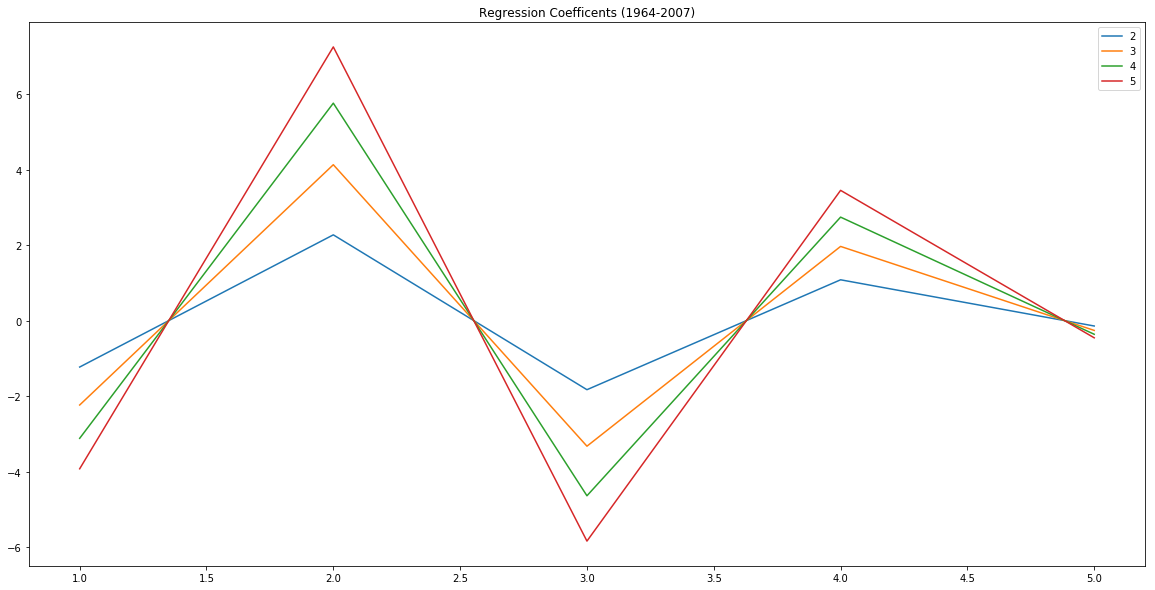

In [126]:
# First Regression
model = LinearRegression()
R_sq_model = np.zeros(4)

model.fit(ft_train5,rxt_bar_train5)
gamma = model.coef_
R_sq_model = model.score(ft_train5,rxt_bar_train5)

# Second Regression
aux = pd.DataFrame(np.sum((ft_train5).mul(gamma), axis = 1) + model.intercept_)

aux_test = pd.DataFrame(np.sum((ft_test5).mul(gamma), axis = 1) + model.intercept_)

models = []
b = np.zeros(4)
R_sq = np.zeros(4)
rxt_predict = rxt_test5.copy()

for i in range(4):
    model_b = LinearRegression(fit_intercept=False)
    model_b.fit(aux,rxt_train5.iloc[:,i])
    b[i] = model_b.coef_[0]
    rxt_predict.iloc[:,i] = model_b.predict(aux_test)
    R_sq[i] = model_b.score(aux_test,rxt_test5.iloc[:,i])
    models.append(model_b)
plt.figure(figsize=(20,10))
#pre = 0
for i in range(4):
    plt.plot(range(1,6),b[i]*gamma, label = str(i+2))
#    pre = pre + ft_test5.mul(b[i]*gamma)
rxt_predict_bar = np.mean(rxt_predict, axis = 1)
plt.legend()
plt.title('Regression Coefficents (1964-2007)')
plt.show();

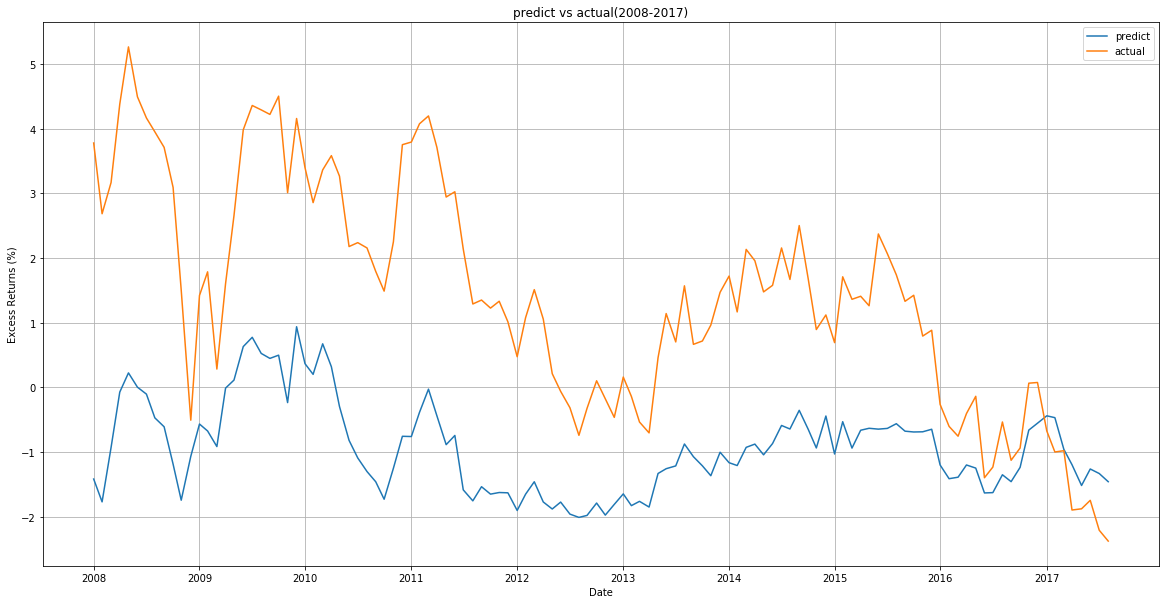

array([-1.44791491, -1.53660337, -1.42591115, -1.26932303])

In [127]:
plt.figure(figsize=(20,10))
plt.plot(rxt_predict_bar*100, label='predict')
plt.plot(rxt_bar_test5*100, label='actual')
#plt.plot(np.sum(pre*100, axis = 1)/4, label='x')
plt.xticks(rxt_bar_test5.index[::12])
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(2008-2017)')
plt.show();
R_sq

In [131]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ft5.values, i) for i in range(ft5.shape[1])]
vif["features"] = ft5.columns

In [132]:
vif

,VIF Factor,features
0,476.636507,SVENY01
1,20283.483079,SVENY02
2,164700.572466,SVENY03
3,243596.829496,SVENY04
4,44487.460169,SVENY05


### Analysis of Predicted VS Actual Excess Returns

In [82]:
# Correlation between actual and predicted average excess returns with train set 1964 - 2008 and test set 2008 - 2018
np.corrcoef(rxt_predict_bar, rxt_bar_test5)

array([[ 1.        ,  0.67746323],
       [ 0.67746323,  1.        ]])

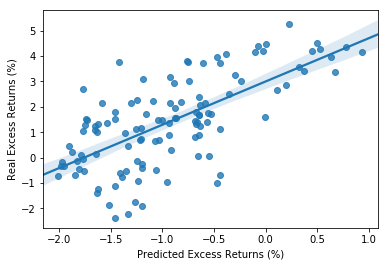

In [83]:
import seaborn as sns
ax = sns.regplot(x=rxt_predict_bar*100, y=rxt_bar_test5*100)
ax.set(xlabel = "Predicted Excess Returns (%)", ylabel = "Real Excess Returns (%)")
plt.show()

## FEDs DATA: Train set (1964 - 2007), Test set (2008 - 2018). Up to 10-year maturities

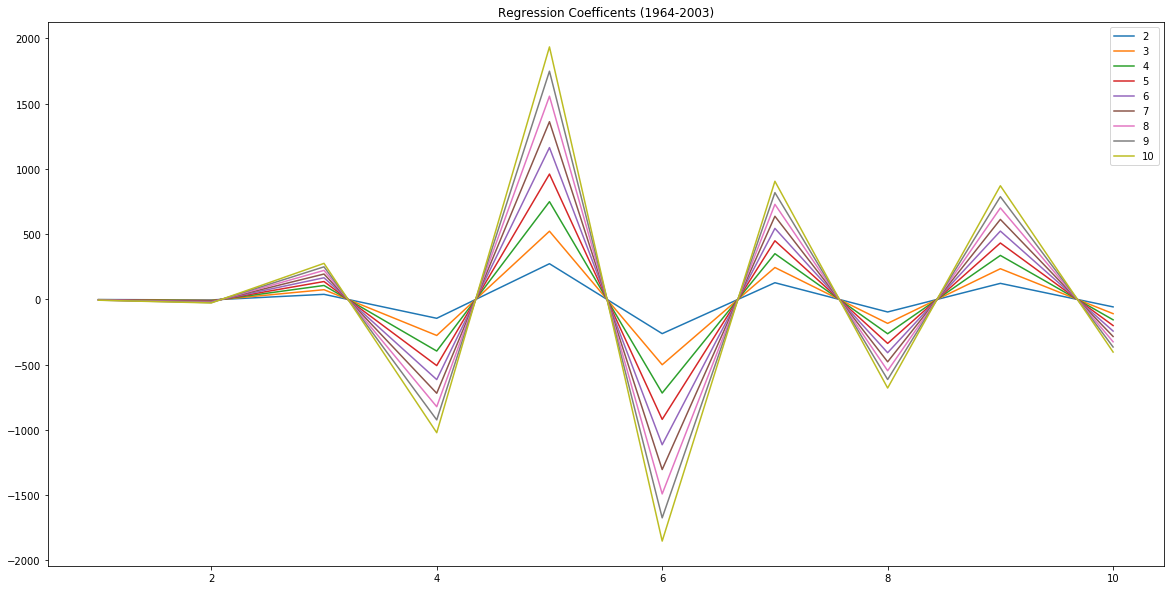

In [87]:
model = LinearRegression()
R_sq = np.zeros(9)

model.fit(ft_train10,rxt_bar_train10)
gamma = model.coef_
R_sq = model.score(ft_train10,rxt_bar_train10)

aux = pd.DataFrame(np.sum((ft_train10).mul(gamma), axis = 1) + model.intercept_)
#aux.insert(0, 'ones', np.ones(len(aux)))

aux_test = pd.DataFrame(np.sum((ft_test10).mul(gamma), axis = 1) + model.intercept_)
#aux_test.insert(0, 'ones', np.ones(len(aux_test))) 

models = []
b = np.zeros(9)
R_sq = np.zeros(9)
rxt_predict = rxt_test10.copy()

for i in range(9):
    model_b = LinearRegression()
    model_b.fit(aux,rxt_train10.iloc[:,i])
    b[i] = model_b.coef_[0]
    rxt_predict.iloc[:,i] = model_b.predict(aux_test)
    R_sq[i] = model_b.score(aux_test,rxt_test10.iloc[:,i])
    models.append(model_b)
plt.figure(figsize=(20,10))
#pre = 0
for i in range(9):
    plt.plot(range(1,11),b[i]*gamma, label = str(i+2))
#    pre = pre + ft_test10.mul(b[i]*gamma)
rxt_predict_bar = np.mean(rxt_predict, axis = 1)
plt.legend()
plt.title('Regression Coefficents (1964-2003)')
plt.show();

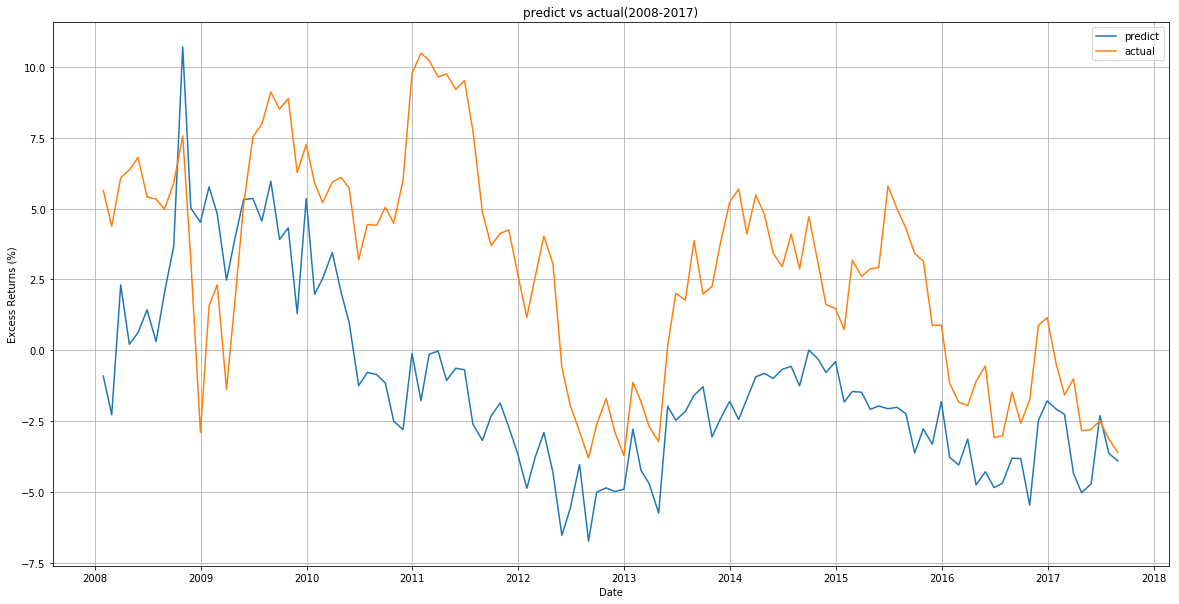

array([-0.51888008, -0.79056412, -0.852604  , -0.83518069, -0.81012876,
       -0.79821834, -0.80171899, -0.81771925, -0.84242578])

In [88]:
plt.figure(figsize=(20,10))
plt.plot(rxt_predict_bar*100, label='predict')
plt.plot(rxt_bar_test10*100, label='actual')
#plt.plot(np.sum(pre*100, axis = 1)/9, label='x')
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(2008-2017)')
plt.show();
R_sq

### Analysis of Predicted VS Actual Excess Returns

In [70]:
# Correlation between actual and predicted average excess returns with train set 1964 - 2008 and test set 2008 - 2018
np.corrcoef(rxt_predict_bar, rxt_bar_test10)

array([[ 1.        ,  0.58926337],
       [ 0.58926337,  1.        ]])

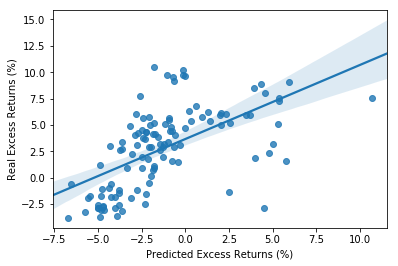

In [71]:
import seaborn as sns
ax = sns.regplot(x=rxt_predict_bar*100, y=rxt_bar_test10*100)
ax.set(xlabel = "Predicted Excess Returns (%)", ylabel = "Real Excess Returns (%)")
plt.show()

## Regression Series for 10-year Period. Coefficients Comparison

In [76]:
def simple_model_regressions (start_train, end_train, start_test, end_test, 
                              returns_data, forwards_data, excess_ret_data, maturity):
    
    # Determine Date periods
    idx = ((returns_data.index > pd.to_datetime(start_train)) &
           (returns_data.index < pd.to_datetime(end_test)))
    idx_train = ((returns_data.index > pd.to_datetime(start_train)) & 
                  (returns_data.index < pd.to_datetime(end_train)))
    idx_test = ((returns_data.index > pd.to_datetime(start_test)) &
                 (returns_data.index < pd.to_datetime(end_test)))

    # Select appropiate data and divide it into train set and test set
    yt = returns_data[idx].iloc[:,1:(maturity+1)]
    ft = forwards_data[idx].iloc[:,1:(maturity+1)]
    rxt = excess_ret_data[idx].iloc[:,2:(maturity+1)]
    rxt_bar = rxt.mean(axis = 1)

    # Select 5 year train data
    yt_train = returns_data[idx_train].iloc[:,1:(maturity+1)]
    ft_train = forwards_data[idx_train].iloc[:,1:(maturity+1)]
    rxt_train = excess_ret_data[idx_train].iloc[:,2:(maturity+1)]
    rxt_bar_train = rxt_train.mean(axis = 1)

    # Select 5 year test data
    yt_test = returns_data[idx_test].iloc[:,1:(maturity+1)]
    ft_test = forwards_data[idx_test].iloc[:,1:(maturity+1)]
    rxt_test = excess_ret_data[idx_test].iloc[:,2:(maturity+1)]
    rxt_bar_test = rxt_test.mean(axis = 1)
    # First Regression
    model = LinearRegression()
    R_sq = np.zeros((maturity-1))

    model.fit(ft_train,rxt_bar_train)
    gamma = model.coef_
    R_sq = model.score(ft_train,rxt_bar_train)

    # Second Regression
    aux = pd.DataFrame(np.sum((ft_train).mul(gamma), axis = 1) + model.intercept_)

    aux_test = pd.DataFrame(np.sum((ft_test).mul(gamma), axis = 1) + model.intercept_)

    models = []
    b = np.zeros((maturity-1))
    reg_coefs = np.zeros([maturity,maturity-1])
    R_sq = np.zeros((maturity-1))
    rxt_predict = rxt_test.copy()

    for i in range((maturity-1)):
        model_b = LinearRegression()
        model_b.fit(aux,rxt_train.iloc[:,i])
        b[i] = model_b.coef_[0]
        reg_coefs[:,i] = b[i]*gamma
        rxt_predict.iloc[:,i] = model_b.predict(aux_test)
        R_sq[i] = model_b.score(aux_test,rxt_test.iloc[:,i])
        models.append(model_b)
    rxt_predict_bar = np.mean(rxt_predict, axis = 1)

    return gamma, b, reg_coefs, rxt_predict, rxt_predict_bar, rxt_bar

In [116]:
g, b_x, reg_co, pre, pre_bar, rxt_average = simple_model_regressions('1964-1-1','1974-1-1','1964-1-1','2017-9-1',y, f, rx, 5)

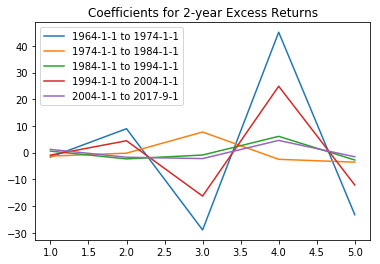

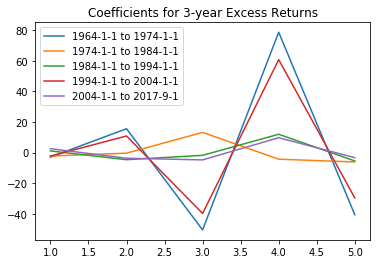

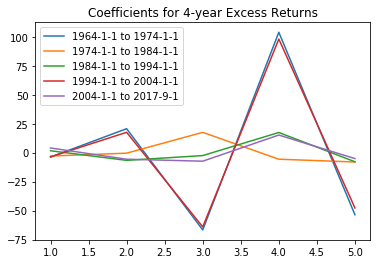

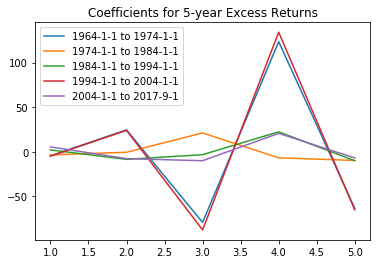

In [114]:
starting_dates = ['1964-1-1','1974-1-1','1984-1-1','1994-1-1','2004-1-1','2017-9-1']
for i in range(len(starting_dates)-1):
    g, b_x, reg_co, pre, pre_bar, rxt_average = (
        simple_model_regressions(starting_dates[i],starting_dates[i+1],starting_dates[i],starting_dates[i+1],
                                 y, f, rx, 5))
    plt.figure(1)
    plt.plot(range(1,6),reg_co[:,0], label = starting_dates[i] + " to " + starting_dates[i+1])
    plt.legend()
    plt.title("Coefficients for 2-year Excess Returns")
    plt.figure(2)
    plt.plot(range(1,6),reg_co[:,1], label = starting_dates[i] + " to " + starting_dates[i+1])
    plt.title("Coefficients for 3-year Excess Returns")
    plt.legend()
    plt.figure(3)
    plt.plot(range(1,6),reg_co[:,2], label = starting_dates[i] + " to " + starting_dates[i+1])
    plt.title("Coefficients for 4-year Excess Returns")
    plt.legend() 
    plt.figure(4)
    plt.plot(range(1,6),reg_co[:,3], label = starting_dates[i] + " to " + starting_dates[i+1])
    plt.title("Coefficients for 5-year Excess Returns")
    plt.legend() 
plt.show()

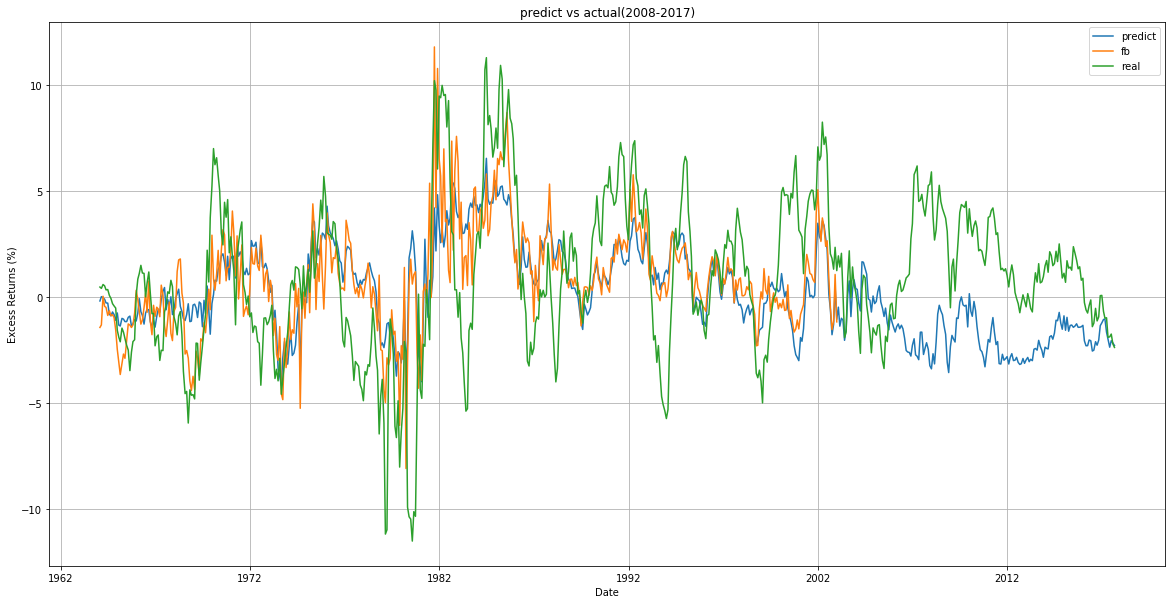

array([-1.44791491, -1.53660337, -1.42591115, -1.26932303])

In [86]:
plt.figure(figsize=(20,10))
plt.plot(pre_bar*100, label='predict')
plt.plot(fb_rxt_predict_bar*100, label='fb')
plt.plot(rxt_average*100, label='real')
plt.xlabel("Date")
plt.ylabel("Excess Returns (%)")
plt.legend()
plt.grid(True)
plt.title('predict vs actual(2008-2017)')
plt.show();
R_sq

# VIF and Multicolinearity

In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [124]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(ft5.values, i) for i in range(ft5.shape[1])]
vif["features"] = ft5.columns

In [125]:
vif

,VIF Factor,features
0,476.636507,SVENY01
1,20283.483079,SVENY02
2,164700.572466,SVENY03
3,243596.829496,SVENY04
4,44487.460169,SVENY05
